### Set

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import warnings
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
# from argparse import ArgumentParser

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset

from torchvision import transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder

import seaborn as sns
from matplotlib.ticker import MaxNLocator

In [3]:
config = {
    'epoch': 10,
    'exp_name':'augmentation',
    'resize':224,
    'degree':10,
    'batch':64,
    'lr':6e-6,
    'decay':0.9,
    'augmentation':True
}

In [4]:
def measurement(outputs, labels, smooth=1e-10):
    tp, tn, fp, fn = smooth, smooth, smooth, smooth
    labels = labels.cpu().numpy()
    outputs = outputs.detach().cpu().clone().numpy()
    for j in range(labels.shape[0]):
        if (int(outputs[j]) == 1 and int(labels[j]) == 1):
            tp += 1
        if (int(outputs[j]) == 0 and int(labels[j]) == 0):
            tn += 1
        if (int(outputs[j]) == 1 and int(labels[j]) == 0):
            fp += 1
        if (int(outputs[j]) == 0 and int(labels[j]) == 1):
            fn += 1
    return tp, tn, fp, fn

def plot_accuracy(train_acc_list, val_acc_list):
    # create figure and axis objects
    fig, ax = plt.subplots(figsize=(8, 6))

    # plot training accuracy curve
    ax.plot(train_acc_list, label='Training Accuracy')

    # plot validation accuracy curve
    ax.plot(val_acc_list, label='Validation Accuracy')

    # set axis labels and title
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy')
    ax.set_title('Training and Validation Accuracy')

    # add legend
    ax.legend()

    # display the plot
    plt.show()
    
    # save the plot
    fig.savefig(config['exp_name']+'_accuracy_plot.png')

    # return the figure object
    return fig


def plot_f1_score(f1_score_list):
    # create figure and axis objects
    fig, ax = plt.subplots(figsize=(8, 6))

    # plot f1 score curve
    ax.plot(f1_score_list, label='F1 Score')

    # set axis labels and title
    ax.set_xlabel('Epochs')
    ax.set_ylabel('F1 Score')
    ax.set_title('Testing F1 Score')

    # add legend
    ax.legend()

    # save the plot
    fig.savefig(config['exp_name']+'_f1_score_plot.png')

    # return the figure object
    return fig

def plot_confusion_matrix(confusion_matrix):
    # create figure and axis objects
    fig, ax = plt.subplots(figsize=(8, 6))

    # plot confusion matrix
    sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')

    # set axis labels and title
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_title('Confusion Matrix')

    # save the plot
    fig.savefig(config['exp_name']+'_confusion_matrix_plot.png')

    # return the figure object
    return fig

def train(device, train_loader, model, criterion, optimizer):
    best_acc = 0.0
    best_model_wts = None
    train_acc_list = []
    val_acc_list = []
    f1_score_list = []
    best_c_matrix = []

    for epoch in range(1, config['epoch']+1):

        with torch.set_grad_enabled(True):
            avg_loss = 0.0
            train_acc = 0.0
            tp, tn, fp, fn = 0, 0, 0, 0     
            for _, data in enumerate(tqdm(train_loader)):
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                avg_loss += loss.item()
                outputs = torch.max(outputs, 1).indices
                sub_tp, sub_tn, sub_fp, sub_fn = measurement(outputs, labels)
                tp += sub_tp
                tn += sub_tn
                fp += sub_fp
                fn += sub_fn          

            avg_loss /= len(train_loader.dataset)
            train_acc = (tp+tn) / (tp+tn+fp+fn) * 100
            print(f'Epoch: {epoch}')
            print(f'↳ Loss: {avg_loss}')
            print(f'↳ Training Acc.(%): {train_acc:.2f}%')

        val_acc, f1_score, c_matrix = test(test_loader, model)
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
        f1_score_list.append(f1_score)

        if val_acc > best_acc:
            best_acc = val_acc
            best_c_matrix = c_matrix
            torch.save(model.state_dict(), config['exp_name']+'_best_model_weights.pt')

    return train_acc_list, val_acc_list, f1_score_list, best_c_matrix

def test(test_loader, model):
    val_acc = 0.0
    tp, tn, fp, fn = 0, 0, 0, 0
    with torch.set_grad_enabled(False):
        model.eval()
        for images, labels in test_loader:
            
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            outputs = torch.max(outputs, 1).indices

            sub_tp, sub_tn, sub_fp, sub_fn = measurement(outputs, labels)
            tp += sub_tp
            tn += sub_tn
            fp += sub_fp
            fn += sub_fn

        c_matrix = [[int(tp), int(fn)],
                    [int(fp), int(tn)]]
        
        val_acc = (tp+tn) / (tp+tn+fp+fn) * 100
        recall = tp / (tp+fn)
        precision = tp / (tp+fp)
        f1_score = (2*tp) / (2*tp+fp+fn)
        print (f'↳ Recall: {recall:.4f}, Precision: {precision:.4f}, F1-score: {f1_score:.4f}')
        print (f'↳ Test Acc.(%): {val_acc:.2f}%')

    return val_acc, f1_score, c_matrix

### main code

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'## Now using {device} as calculating device ##')

## Now using cuda as calculating device ##


In [6]:
# x3 dataset

#     # set dataloader
#     original_transforms = transforms.Compose([
#         transforms.Resize((config['resize'], config['resize'])),
#         transforms.ToTensor()
#     ])

#     # Define transforms for the augmented dataset
#     augmented_transforms_sample = transforms.Compose([
#         transforms.Resize((config['resize'], config['resize'])),
#         transforms.RandomRotation(config['degree'], resample=False), #90 is too large 10 seems more reasonable
#         transforms.ToTensor()
#     ])
    
#     augmented_transforms = transforms.Compose([
#         transforms.Resize((config['resize'], config['resize'])),
#         transforms.RandomRotation(config['degree'], resample=False), #90 is too large 10 seems more reasonable
#         transforms.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.2, hue=0.1), # add ColorJitter
#     #     transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=15, resample=False, fillcolor=0),
#     #     transforms.RandomHorizontalFlip(), # not reasonable
#     #     transforms.RandomVerticalFlip(), # not reasonable
#         transforms.ToTensor()
#     ])

#     # Create the original dataset
#     original_dataset = ImageFolder(root=os.path.join('chest_xray/train'), transform=original_transforms)

#     # Create the augmented dataset
#     augmented_dataset_sample = ImageFolder(root=os.path.join('chest_xray/train'), transform=augmented_transforms_sample)
#     augmented_dataset = ImageFolder(root=os.path.join('chest_xray/train'), transform=augmented_transforms)

#     # Combine the datasets using ConcatDataset
#     combined_dataset = ConcatDataset([original_dataset, augmented_dataset_sample, augmented_dataset])
    
#     test_dataset = ImageFolder(root=os.path.join('chest_xray/test'),
#                                transform = transforms.Compose([transforms.Resize((config['resize'], config['resize'])),
#                                                                transforms.ToTensor()]))

#     train_loader = DataLoader(combined_dataset, batch_size=config['batch'], shuffle=True)
#     test_loader = DataLoader(test_dataset, batch_size=config['batch'], shuffle=False)

In [7]:
if config['augmentation']:
    train_dataset = ImageFolder(root=os.path.join('chest_xray/train'),
                                transform = transforms.Compose([transforms.Resize((config['resize'],config['resize'])),
                                                                transforms.RandomRotation(config['degree'], resample=False), #90 is too large 10 seems more reasonable
                                                                transforms.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.2, hue=0.1), # add ColorJitter
                                                                # transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=15, resample=False, fillcolor=0),
                                                                # transforms.RandomHorizontalFlip(), # not reasonable
                                                                # transforms.RandomVerticalFlip(), # not reasonable
                                                                transforms.ToTensor()]))

    test_dataset = ImageFolder(root=os.path.join('chest_xray/test'),
                               transform = transforms.Compose([transforms.Resize((config['resize'],config['resize'])),
                                                               transforms.ToTensor()]))

    train_loader = DataLoader(train_dataset, batch_size=config['batch'], shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=config['batch'], shuffle=False)
    
else:
    train_dataset = ImageFolder(root=os.path.join('chest_xray/train'),
                                transform = transforms.Compose([transforms.Resize((config['resize'],config['resize'])),
                                                                transforms.RandomRotation(config['degree'], resample=False),
                                                                transforms.ToTensor()]))

    test_dataset = ImageFolder(root=os.path.join('chest_xray/test'),
                               transform = transforms.Compose([transforms.Resize((config['resize'],config['resize'])),
                                                               transforms.ToTensor()]))

    train_loader = DataLoader(train_dataset, batch_size=config['batch'], shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=config['batch'], shuffle=False)

In [8]:
 # define model
# model = models.resnet18(pretrained=True)
model = models.resnet50(pretrained=True)
num_neurons = model.fc.in_features
model.fc = nn.Linear(num_neurons, 2)
model = model.to(device)

In [9]:
# define loss function, optimizer
criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor([3.8896346, 1.346]))
criterion = criterion.to(device)
optimizer = optim.Adam(model.parameters(), lr=config['lr'], weight_decay=config['decay'])

In [10]:
# training
train_acc_list, val_acc_list, f1_score_list, best_c_matrix = train(device, train_loader, model, criterion, optimizer)

100%|███████████████████████████████████████████████████████████████████████████████████| 82/82 [05:35<00:00,  4.09s/it]


Epoch: 1
↳ Loss: 0.009976452467905962
↳ Training Acc.(%): 61.94%
↳ Recall: 0.7846, Precision: 0.6986, F1-score: 0.7391
↳ Test Acc.(%): 65.38%


100%|███████████████████████████████████████████████████████████████████████████████████| 82/82 [04:44<00:00,  3.47s/it]


Epoch: 2
↳ Loss: 0.005432510791357858
↳ Training Acc.(%): 88.25%
↳ Recall: 0.9154, Precision: 0.8561, F1-score: 0.8848
↳ Test Acc.(%): 85.10%


100%|███████████████████████████████████████████████████████████████████████████████████| 82/82 [03:14<00:00,  2.37s/it]


Epoch: 3
↳ Loss: 0.0025532454597917984
↳ Training Acc.(%): 93.90%
↳ Recall: 0.9667, Precision: 0.8359, F1-score: 0.8966
↳ Test Acc.(%): 86.06%


100%|███████████████████████████████████████████████████████████████████████████████████| 82/82 [03:09<00:00,  2.31s/it]


Epoch: 4
↳ Loss: 0.001984397440068881
↳ Training Acc.(%): 95.36%
↳ Recall: 0.9769, Precision: 0.8283, F1-score: 0.8965
↳ Test Acc.(%): 85.90%


100%|███████████████████████████████████████████████████████████████████████████████████| 82/82 [03:09<00:00,  2.31s/it]


Epoch: 5
↳ Loss: 0.0017176977618728862
↳ Training Acc.(%): 96.11%
↳ Recall: 0.9846, Precision: 0.8458, F1-score: 0.9100
↳ Test Acc.(%): 87.82%


100%|███████████████████████████████████████████████████████████████████████████████████| 82/82 [03:09<00:00,  2.32s/it]


Epoch: 6
↳ Loss: 0.0014732341943422985
↳ Training Acc.(%): 96.24%
↳ Recall: 0.9846, Precision: 0.8223, F1-score: 0.8961
↳ Test Acc.(%): 85.74%


100%|███████████████████████████████████████████████████████████████████████████████████| 82/82 [02:33<00:00,  1.87s/it]


Epoch: 7
↳ Loss: 0.0013963757436351132
↳ Training Acc.(%): 96.45%
↳ Recall: 0.9795, Precision: 0.8489, F1-score: 0.9095
↳ Test Acc.(%): 87.82%


100%|███████████████████████████████████████████████████████████████████████████████████| 82/82 [02:34<00:00,  1.89s/it]


Epoch: 8
↳ Loss: 0.00133996638305131
↳ Training Acc.(%): 96.72%
↳ Recall: 0.9795, Precision: 0.8623, F1-score: 0.9172
↳ Test Acc.(%): 88.94%


100%|███████████████████████████████████████████████████████████████████████████████████| 82/82 [02:33<00:00,  1.87s/it]


Epoch: 9
↳ Loss: 0.001355542971658309
↳ Training Acc.(%): 96.70%
↳ Recall: 0.9744, Precision: 0.8716, F1-score: 0.9201
↳ Test Acc.(%): 89.42%


100%|███████████████████████████████████████████████████████████████████████████████████| 82/82 [02:33<00:00,  1.88s/it]


Epoch: 10
↳ Loss: 0.0011452942357421424
↳ Training Acc.(%): 97.14%
↳ Recall: 0.9897, Precision: 0.8373, F1-score: 0.9072
↳ Test Acc.(%): 87.34%


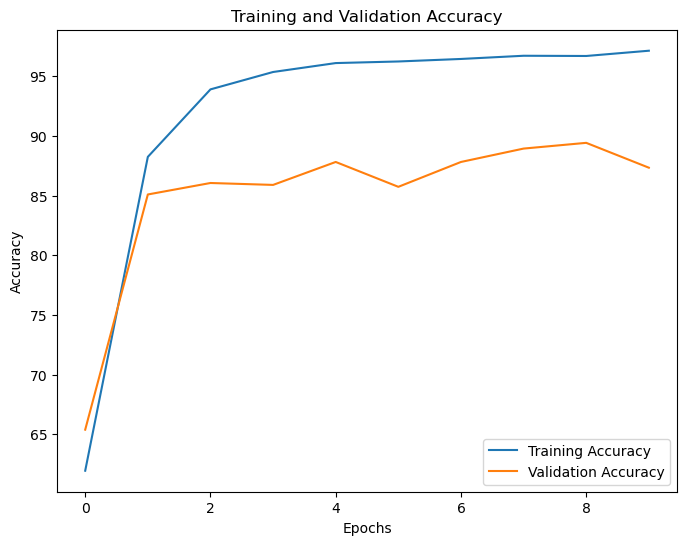

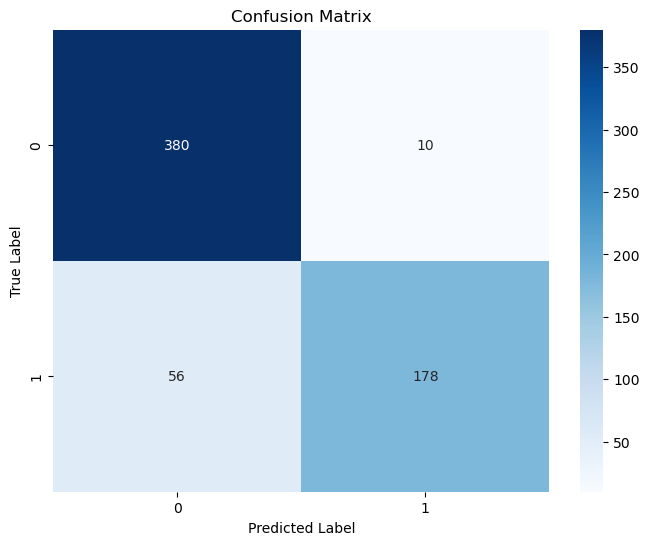

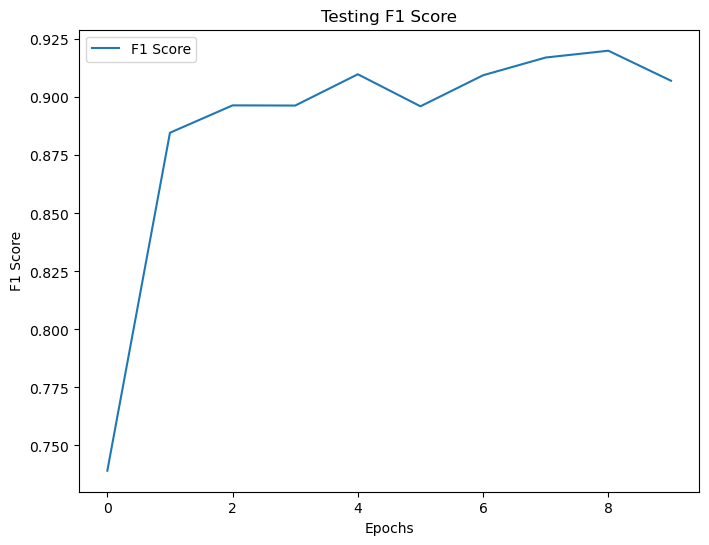

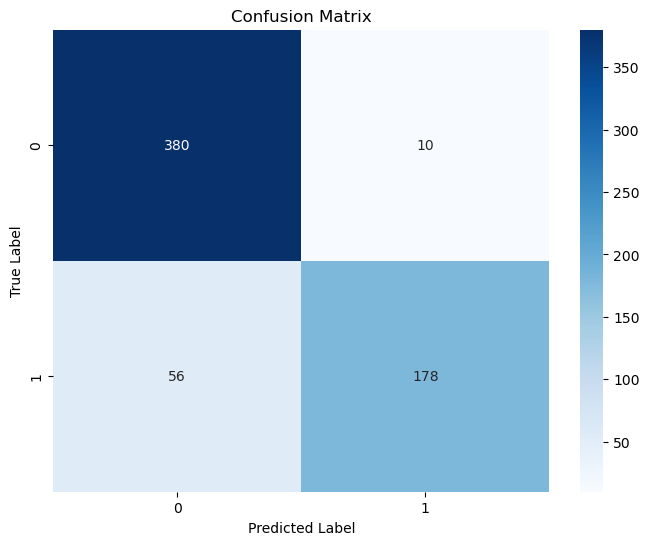

In [11]:
# plot
plot_accuracy(train_acc_list, val_acc_list)
plot_f1_score(f1_score_list)
plot_confusion_matrix(best_c_matrix)